In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [4]:
# Check outcomes of each trial
trial_outcomes = np.array(rp.get('markers'))
trial_outcomes = trial_outcomes[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get frequencies of trial outcomes
trial_outcomes_freq = dict()
for trial in trial_outcomes:
    if trial not in trial_outcomes_freq:
        trial_outcomes_freq[trial] = 1
    else:
        trial_outcomes_freq[trial] += 1

print(trial_outcomes_freq)


{3: 400, 4: 41}


In [5]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

In [6]:
# Get time intervals for navigation phases
nav_timestamps = trial_timestamps[1:,:].T

# Bin navigation phases into 1-second time bins
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

In [7]:
# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [8]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(timebins_per_nav_phase.shape, dtype=np.int8)
min_dur, max_dur = 2, 25  # minimum and maximum duration of trials (in seconds) to filter out

prev_goal = 0
for num, dur in enumerate(timebins_per_nav_phase):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
# for num, dur in enumerate(timebins_per_nav_phase):
#     if dur < min_dur or dur > max_dur:
#         good_trials[num] = 0

trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
timebins_per_nav_phase = timebins_per_nav_phase[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [9]:
# # Pool cue phase and navigation phase intervals together to get session intervals
# session_intervals = list()
# for num, nav_phase in enumerate(nav_intervals):
#     session_intervals.append(cue_intervals[num])
#     for intvl in nav_phase:
#         session_intervals.append(intvl)
# session_intervals = np.array(session_intervals)

# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

In [10]:
# Slot spikes into cue phase intervals
spikecounts_cue = spike_counts_per_observation(cue_intervals, spike_times)

# Slot spikes into navigation phase intervals
spikecounts_nav = list()
for phase in nav_intervals:
    spikecounts_nav.append(spike_counts_per_observation(phase, spike_times))

# Slot spikes into session time intervals
spikecounts_session = spike_counts_per_observation(session_intervals, spike_times)

In [11]:
# Bin spike counts within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_session = np.empty_like(spikecounts_session)
binning_stats = list()
for col in range(spikecounts_session.shape[1]):
    binned_spikes_session[:,col] = bin_firing_rates_4(spikecounts_session[:,col])
    binning_stats.append(get_binning_stats_4(spikecounts_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_cue = np.empty_like(spikecounts_cue)
for col in range(spikecounts_cue.shape[1]):
    binned_spikes_cue[:,col] = bin_firing_rates_4(spikecounts_cue[:,col], stats=binning_stats[col])

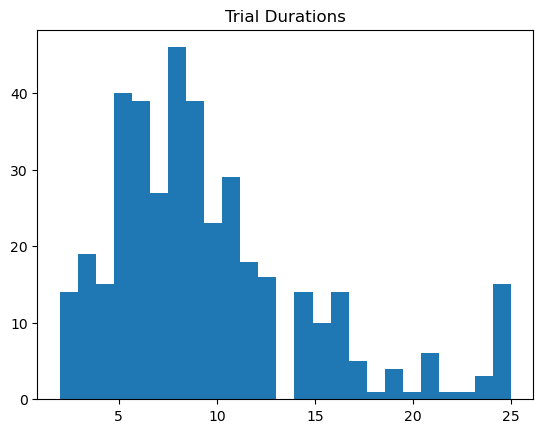

In [12]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Plot distribution of trial durations
import matplotlib.pyplot as plt

plt.figure()
plt.title('Trial Durations')
plt.hist(timebins_per_nav_phase, bins=25)
plt.show()

In [13]:
# Get quantiles of trial duration distribution
trial_dur_25 = np.percentile(timebins_per_nav_phase, 25)
trial_dur_50 = np.median(timebins_per_nav_phase)
trial_dur_75 = np.percentile(timebins_per_nav_phase, 75)
trial_dur_min = min(timebins_per_nav_phase)

print(f'Percentage of trials longer than __ seconds (sample size: {timebins_per_nav_phase.shape[0]}):')
print(f'25%: {trial_dur_75}, 50%: {trial_dur_50}, 75%: {trial_dur_25}, min: {trial_dur_min}')

Percentage of trials longer than __ seconds (sample size: 400):
25%: 12.0, 50%: 8.5, 75%: 6.0, min: 2


In [14]:
# Filter out trials with navigation phases less than time_diff seconds
time_diff = 5  # Seconds after end of cue phase to sampled nav phase time bin
filt = np.where(timebins_per_nav_phase >= time_diff)

trial_markers_filt = trial_markers[filt]
spikecounts_nav = list(filter(lambda arr: arr.shape[0] >= time_diff, spikecounts_nav))

In [15]:
# Select time bin time_diff seconds after cue phase for each navigation phase
spikecounts_nav = np.array(list(map(lambda arr: arr[time_diff-1,:], spikecounts_nav)))

# Bin spike counts within each cell for navigation phases
binned_spikes_nav = np.empty_like(spikecounts_nav)
for col in range(spikecounts_nav.shape[1]):
    binned_spikes_nav[:,col] = bin_firing_rates_4(spikecounts_nav[:,col], stats=binning_stats[col])

In [16]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

In [17]:
# Group cue phase spikes according to goal
responses_per_goal_cue = group_by_goal(binned_spikes_cue, trial_markers)
responses_per_goal_nav = group_by_goal(binned_spikes_nav, trial_markers_filt)

# Get distribution of population responses for cue phase vs entire session
response_distribution_cue = PriorDistributionCell(binned_spikes_session, responses_per_goal_cue)

# Get dirstribution of population responses for navigation phase vs entire session
response_distribution_nav = PriorDistributionCell(binned_spikes_session, responses_per_goal_nav)

In [18]:
# Some important constants
num_goals = 6
num_cells = len(cell_list)
num_cats = 4

constants = (num_goals, num_cells, num_cats)

In [19]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = response_distribution_cue.P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(goal_entropy)

2.573664397104504


In [20]:
np.log2(6)

2.584962500721156

In [21]:
def information_gain(response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    info_gain = np.zeros((num_goals, num_cells))
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_dist.P_r_s(cell, cat, goal)
                P_r = response_dist.P_r(cell, cat)
                if P_r_s != 0:
                    info_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
    return info_gain

def net_information_gain(info_gain: np.array, response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    net_info_gain = np.zeros(num_cells)
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = info_gain[goal, cell]
            P_s = response_dist.P_s(goal)
            net_info_gain[cell] += P_s * I_s_R
    return net_info_gain

In [22]:
# Information gain per stimulus (relative to entire session responses)
information_gain_cue = np.zeros((num_goals, num_cells))
information_gain_nav = np.zeros((num_goals, num_cells))

for goal in range(num_goals):
    for cell in range(num_cells):
        for cat in range(num_cats):
            P_r_s = response_distribution_cue.P_r_s(cell, cat, goal)
            P_r = response_distribution_cue.P_r(cell, cat)
            if P_r_s != 0:
                information_gain_cue[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
            
            P_r_s = response_distribution_nav.P_r_s(cell, cat, goal)
            P_r = response_distribution_nav.P_r(cell, cat)
            if P_r_s != 0:
                information_gain_nav[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
            

In [23]:
# Net information gain acrosss entire stimuli set
net_information_gain_cue = np.zeros(num_cells)
net_information_gain_nav = np.zeros(num_cells)

for cell in range(num_cells):
    for goal in range(num_goals):
        I_s_R = information_gain_cue[goal, cell]
        P_s = response_distribution_cue.P_s(goal)
        net_information_gain_cue[cell] += P_s * I_s_R

        I_s_R = information_gain_nav[goal, cell]
        P_s = response_distribution_nav.P_s(goal)
        net_information_gain_nav[cell] += P_s * I_s_R

print(f'Cue: {net_information_gain_cue}')
print(f'Nav: {net_information_gain_nav}')

Cue: [0.00776766 0.13831873 0.         0.         0.33063682 0.23866298
 0.05217741 0.05109419 0.06451824 0.07499016 0.22138719 0.
 0.        ]
Nav: [0.00471139 0.03320651 0.         0.         0.03967641 0.06166316
 0.04750152 0.04018559 0.06271451 0.02662556 0.02148001 0.
 0.        ]


In [24]:
net_info_gain_ratio = np.divide(net_information_gain_cue, net_information_gain_nav, out=np.zeros_like(net_information_gain_cue), where=net_information_gain_nav!=0)
net_info_gain_ratio

array([ 1.64869848,  4.1654105 ,  0.        ,  0.        ,  8.33333439,
        3.87043035,  1.09843655,  1.27145561,  1.02876094,  2.81647294,
       10.30666297,  0.        ,  0.        ])

In [25]:
def net_information_gain_ratio(data: tuple, constants: tuple) -> np.array:
    # Unpacking main data variables and constants
    binned_spikes_nav, binned_spikes_session, trial_markers, net_information_gain_cue = data
    num_goals, num_cells, num_cats = constants

    # Group cue phase spikes according to goal
    responses_per_goal_nav = group_by_goal(binned_spikes_nav, trial_markers)

    # Get distribution of population responses for cue phase and navigation phase vs entire session
    response_distribution_nav = PriorDistributionCell(binned_spikes_session, responses_per_goal_nav)

    # Information gain per stimulus (relative to entire session responses)
    information_gain_nav = information_gain(response_distribution_nav, constants)

    # Net information gain acrosss entire stimuli set
    net_information_gain_nav = net_information_gain(information_gain_nav, response_distribution_nav, constants)

    # Net information gain ratio between cue and navigation phase
    res = np.divide(net_information_gain_cue, net_information_gain_nav, out=np.zeros_like(net_information_gain_cue), where=net_information_gain_nav!=0)
    return res

Parameter tuning for Bootstrap/Jackknife error estimation

In [26]:
# # Jackknife estimation procedure
# num_samples = binned_spikes_nav.shape[0]
# indexes = np.arange(num_samples)
# jack_estimates = list()

# for i in range(num_samples):
#     binned_spikes_nav_subset = binned_spikes_nav[indexes!=i,:]
#     trial_markers_subset = trial_markers_filt[indexes!=i]
#     data_subset = binned_spikes_nav_subset, binned_spikes_session, trial_markers_subset, net_information_gain_cue
#     jack_estimates.append(net_information_gain_ratio(data_subset, constants))
# jack_estimates = np.array(jack_estimates)

In [27]:
# # Jackknife mean and variance estimate
# jack_est_mean = np.mean(jack_estimates, axis=0)
# jack_est_std = np.zeros_like(jack_est_mean)
# for i, est in enumerate(jack_estimates):
#     jack_est_std += (est - jack_est_mean)**2
# jack_est_std = np.sqrt((num_samples - 1)/num_samples * jack_est_std)

In [37]:
def bootstrap_estimate(data: tuple, constants: tuple, ratio: float, iters: int, intvl: tuple, replace=True, rng=np.random.default_rng()) -> tuple:
    # Unpack main data variables
    binned_spikes_nav, binned_spikes_session, trial_markers, net_information_gain_cue = data

    # Store net information gain ratio estimate from each bootstrapped sample
    estimates = list()

    # Big loop
    for i in range(iters):

        # Sampling with replacement
        num_samples = binned_spikes_nav.shape[0]
        num_subset = int(round(ratio * num_samples))
        indexes = tuple(rng.choice(num_samples, size=num_subset, replace=replace))
        binned_spikes_nav_subset = binned_spikes_nav[indexes,:]
        trial_markers_subset = trial_markers.reshape(-1,1)[indexes,:][:,0]

        # Calculate net information gain ratio for this sample
        data_subset = binned_spikes_nav_subset, binned_spikes_session, trial_markers_subset, net_information_gain_cue
        estimates.append(net_information_gain_ratio(data_subset, constants))

    # Calculate bootstrapped mean and stdev
    est_mean = np.mean(estimates, axis=0)
    est_std = np.std(estimates, axis=0, ddof=1)
    est_intvl = (np.percentile(estimates, intvl[0], axis=0), np.percentile(estimates, intvl[1], axis=0))
    return est_mean, est_std, est_intvl

In [38]:
# Figure out what is a good number of iterations for jackknifing
data = binned_spikes_nav, binned_spikes_session, trial_markers, net_information_gain_cue
jack_est_means, jack_est_stds, jack_est_intvls = list(), list(), list()
sample_ratio = 0.8
intvl = (5, 95)
iter_range = range(100, 1100, 100)
for iter in iter_range:
    jack_est_mean, jack_est_std, jack_est_intvl = bootstrap_estimate(data, constants, sample_ratio, iter, intvl, replace=False)
    jack_est_means.append(jack_est_mean)
    jack_est_stds.append(jack_est_std)
    jack_est_intvls.append(jack_est_intvl)
jack_est_means = np.array(jack_est_means).T
jack_est_stds = np.array(jack_est_stds).T
jack_est_intvls = np.array(jack_est_intvls).T

In [39]:
# Figure out what is a good number of iterations for bootstrapping
data = binned_spikes_nav, binned_spikes_session, trial_markers, net_information_gain_cue
boot_est_means, boot_est_stds, boot_est_intvls = list(), list(), list()
sample_ratio = 1
intvl = (5, 95)
iter_range = range(100, 1100, 100)
for iter in iter_range:
    boot_est_mean, boot_est_std, boot_est_intvl = bootstrap_estimate(data, constants, sample_ratio, iter, intvl)
    boot_est_means.append(boot_est_mean)
    boot_est_stds.append(boot_est_std)
    boot_est_intvls.append(boot_est_intvl)
boot_est_means = np.array(boot_est_means).T
boot_est_stds = np.array(boot_est_stds).T
boot_est_intvls = np.array(boot_est_intvls).T

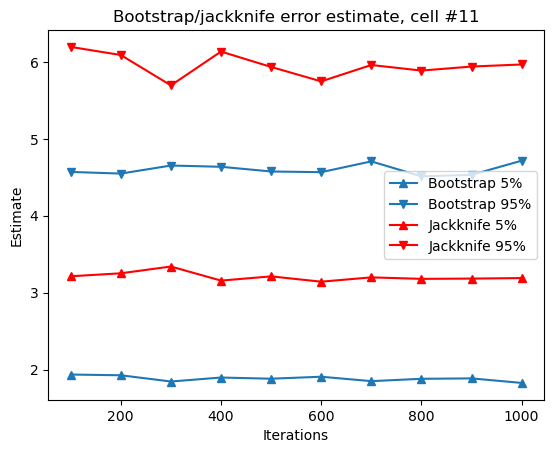

In [59]:
# Plot 5/95 percentile points of one particular cell
cell_num = 10
boot_low = boot_est_intvls[cell_num,0,:]
boot_high = boot_est_intvls[cell_num,1,:]
jack_low = jack_est_intvls[cell_num,0,:]
jack_high = jack_est_intvls[cell_num,1,:]

plt.figure()
plt.title(f'Bootstrap/jackknife error estimate, cell #{cell_num+1}')
plt.plot(iter_range, boot_low, color='C0', marker='^', label='Bootstrap 5%')
plt.plot(iter_range, boot_high, color='C0', marker='v', label='Bootstrap 95%')
plt.plot(iter_range, jack_low, color='r', marker='^', label='Jackknife 5%')
plt.plot(iter_range, jack_high, color='r', marker='v', label='Jackknife 95%')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Estimate')
plt.show()